In [1]:
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install bs4
!pip install nltk
!pip install matplotlib

In [2]:
import pandas as pd
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

In [3]:
import nltk
nltk.download('all', quiet = True)
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

In [4]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

   "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

   "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

   "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

   "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

   "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

   "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

   "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

   "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

   "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

   "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

   "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

   "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

   "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

   "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

   "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

   "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

   "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

   "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

   "you're": "you are", "you've": "you have"
}

stop_words = set(stopwords.words('english')) 

def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [5]:
ids_to_use = []
with open('./video_ids_balanced.json', 'r') as f:
    ids_to_use = json.load(f)

In [6]:
# Read all the data
labels = []
raw_inputs = []
df = pd.read_csv('./raw_data.csv')
max_frames = 0
max_words = 0
max_sequence_length = 0

for index, row in df.iterrows():
    video_id = row['video_id']
    mod_id = video_id + '.npy'
    path = os.path.join('./processed_video', 'audio_' + video_id + '_txt')
    
    if os.path.isfile(path) and mod_id in ids_to_use:
        with open(path, 'r') as f:
            try:
                raw_inputs_video = []
                sequence_length = 0
                file_data = json.load(f)
                num_frames = len(file_data)
                
                if num_frames > max_frames:
                    max_frames = num_frames

                for i in range(num_frames):
                    line_data = json.loads(file_data[i])

                    if 'DisplayText' in line_data.keys():
                        sentence = line_data['DisplayText']
                        cleaned_sentence = text_cleaner(sentence)
                        num_words = len(cleaned_sentence.split())
                        sequence_length = sequence_length + num_words

                        if num_words > max_words:
                            max_words = num_words
                        raw_inputs_video.append(cleaned_sentence)

                    del line_data
                
                raw_inputs.append(raw_inputs_video)
                labels.append((row['video_likeCount'] - row['video_dislikeCount'])/row['video_viewCount'])
                
                if sequence_length > max_sequence_length:
                    max_sequence_length = sequence_length

                del raw_inputs_video, file_data, sequence_length
            except ValueError:
                print(path + ' failed processing')

raw_inputs = np.array(raw_inputs)
labels = np.array(labels)
print()
print('Shape of raw_inputs: ', raw_inputs.shape)
print('Shape of labels: ', labels.shape)
print('Max Words: ', max_words)
print('Max Frames: ', max_frames)
print('Max Sequence Lenghth: ', max_sequence_length)
np.save('./text.npy', raw_inputs)


Shape of raw_inputs:  (961,)
Shape of labels:  (961,)
Max Words:  84
Max Frames:  185
Max Sequence Lenghth:  1229


In [7]:
label_series = pd.Series(labels)
print(label_series.value_counts(bins=20).sort_index())

(-0.0010119, 0.00479]     75
(0.00479, 0.0095]        120
(0.0095, 0.0142]         104
(0.0142, 0.0189]         109
(0.0189, 0.0236]         103
(0.0236, 0.0283]         108
(0.0283, 0.033]          118
(0.033, 0.0377]           90
(0.0377, 0.0425]          62
(0.0425, 0.0472]          25
(0.0472, 0.0519]          18
(0.0519, 0.0566]          14
(0.0566, 0.0613]           5
(0.0613, 0.066]            4
(0.066, 0.0707]            2
(0.0707, 0.0754]           2
(0.0754, 0.0801]           1
(0.0801, 0.0848]           0
(0.0848, 0.0895]           0
(0.0895, 0.0942]           1
dtype: int64


In [8]:
# Prepare data for cnn lstm by concatenating frames, normalizing labels and defining constants
text_inputs = [''.join(row) for row in raw_inputs]
labels = np.clip(labels, 0.00421, 0.037)
min_label = np.min(labels)
max_label = np.max(labels)
scaled_labels = (labels - min_label)/(max_label - min_label)
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = max_sequence_length
VALIDATION_SPLIT = 0.3
GLOVE_DIR = './glove.twitter.27B'
EMBEDDING_DIM = 200

In [9]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text_inputs)
sequences = tokenizer.texts_to_sequences(text_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', scaled_labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = scaled_labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Shape of training tensor:', x_train.shape)
print('Shape of training labels:', y_train.shape)
print('Shape of testing tensor:', x_val.shape)
print('Shape of testing labels:', y_val.shape)

Found 45850 unique tokens.
Shape of data tensor: (961, 1229)
Shape of label tensor: (961,)
Shape of training tensor: (673, 1229)
Shape of training labels: (673,)
Shape of testing tensor: (288, 1229)
Shape of testing labels: (288,)


In [10]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [11]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [12]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [13]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='linear')(x)

model = Model(sequence_input, preds)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

print(model.summary())
plot_model(model, 'balanced_regression.png', show_shapes=True)

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1229)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1229, 200)         9170200   
_________________________________________________________________
conv1d (Conv1D)              (None, 1225, 128)         128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 245, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 44, 128)           82048 

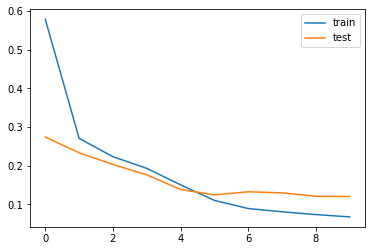

In [14]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [15]:
predictions = model.predict(x_val)
mse = tf.keras.losses.MeanSquaredError()
loss = mse(y_val, predictions)
print('Loss on validation set is %s' % loss.numpy())

Loss on validation set is 0.12900569


No handles with labels found to put in legend.


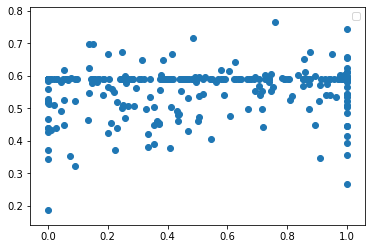

In [16]:
pyplot.scatter(y_val, predictions)
pyplot.legend()
pyplot.show()

In [17]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere(y_val > 0.7))
print('Data points with score more than 0.7 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict(val_data)
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score more than 0.7 108:
Loss on validation set is 0.13392839


In [18]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere(y_val < 0.3))
print('Data points with score less than 0.3 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict(val_data)
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score less than 0.3 92:
Loss on validation set is 0.2032519


In [19]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere((y_val > 0.3) & (y_val < 0.7)))
print('Data points with score greater than 0.3 and less than 0.7 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict(val_data)
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score greater than 0.3 and less than 0.7 88:
Loss on validation set is 0.022490121
